# Determine DEGs in Deseq2 Data

### 1. Import Required Packages
### 2. Import Deseq2 Data
### 3. Find Total Genes, DEGs, lncRNA DEGs, and Protein-Coding DEGs in Hepatocytes
### 4. K-Means Clustering of all Hepatocyte lncRNA DEGs
### 5. Plot k-means data


## <br> 1. Import Required Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
plt.rcParams.update({'font.size': 6}) 

import warnings

In [2]:
# Define the function
def sig_function(row, fold_change_col, p_value_col):
    if row[fold_change_col] >= np.log2(1.5) and row[p_value_col] <= 0.05:
        val = '*'
    elif row[fold_change_col] <= np.log2(1/1.5) and row[p_value_col] <= 0.05:
        val = '*'
    else:
        val = ''
    return val

## Import Genes of interest from each dataset and append together

In [3]:
# Load the named lncRNA DEGs from each snRNAseq dataset
PC_Named_DEGs = pd.read_csv('../01b_RDDR_DEG_Analysis/Results/03f_Named_lncRNAs_DEGs/RDDR_named_lncRNA_DEGs_in_Centrilobular Hepatocytes.txt', sep='\t')
PP_Named_DEGs = pd.read_csv('../01b_RDDR_DEG_Analysis/Results/03f_Named_lncRNAs_DEGs/RDDR_named_lncRNA_DEGs_in_Periportal Hepatocytes.txt', sep='\t')

# Concatenate the DataFrames
GENES = pd.concat([PC_Named_DEGs, PP_Named_DEGs])

# Drop duplicates, keeping the first occurrence
GENES_unique = GENES.drop_duplicates(keep='first')
GENES_unique = GENES_unique.rename(columns={"Row_Name": "Heatmap_Label"})

## <br> 2. Import RDDR Deseq2 Data

In [4]:
# Load DESeq2 results for Repeated Dose Dose Reponse (RDDR)
Deseq2_Directory = '../01b_RDDR_DEG_Analysis/Results/03d_MASTER_Deseq2_Concatonated/RDDR_Deseq2_Master_Wald_with_MGI.txt'

Deseq2_Master_RDDR = pd.read_csv(Deseq2_Directory, 
                            delimiter = '\t',
                            index_col=0)

# Convert 'Dose' column to categorical type
Deseq2_Master_RDDR['Dose'] = Deseq2_Master_RDDR['Dose'].astype('category')

# Create 'Heatmap_Label' by concatenating 'MGI_Symbol' and 'Gene'
Deseq2_Master_RDDR['Heatmap_Label'] = Deseq2_Master_RDDR['MGI_Symbol'] + ' (' + Deseq2_Master_RDDR['Gene'] + ')'

# Load gene percentile data for Repeated Dose Dose Reponse (RDDR)
Percentile_Directory = '../01b_RDDR_DEG_Analysis/Results/03c_Gene_Counts_and_Percentiles/Max_Count_Gene_Percentile_Per_Celltype.txt'

RDDR_Percentile = pd.read_csv(Percentile_Directory, 
                            delimiter = '\t',
                            index_col=0)

## <br> 3. Find AHR and DREs in Genes of Interest

In [5]:
# Select and deduplicate columns for AHR and DRE
AHR_DRE_Master = Deseq2_Master_RDDR[['Heatmap_Label','pDRE','AHR']].drop_duplicates(keep='first')

# Merge gene data with AHR and DRE data
GENES_AHR_DRE = pd.merge(GENES_unique, AHR_DRE_Master, on="Heatmap_Label")

# Create Dataframe to cross-reference gene symbol with Heatmap Label
Genes_Percentile = Deseq2_Master_RDDR[['Heatmap_Label','Gene']].drop_duplicates(keep='first')

GENES_AHR_DRE[['pDRE', 'AHR']] = GENES_AHR_DRE[['pDRE', 'AHR']].applymap(lambda x: 1 if x >= 1 else x)

GENES_AHR_DRE.set_index('Heatmap_Label', inplace=True)



/tmp/local/53384812/ipykernel_3570938/3745011550.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  GENES_AHR_DRE[['pDRE', 'AHR']] = GENES_AHR_DRE[['pDRE', 'AHR']].applymap(lambda x: 1 if x >= 1 else x)


## 4. Process Dose Response Data

In [6]:
PC_Hep = Deseq2_Master_RDDR[Deseq2_Master_RDDR['Celltype'] == 'Centrilobular Hepatocytes']
PP_Hep = Deseq2_Master_RDDR[Deseq2_Master_RDDR['Celltype'] == 'Periportal Hepatocytes']

# Perform the merge based on the 'Gene' columns
PC_Hep_Named = pd.merge(GENES_unique, PC_Hep, on='Heatmap_Label', how='left')
PP_Hep_Named = pd.merge(GENES_unique, PP_Hep, on='Heatmap_Label', how='left')

PC_Percentile_Hep = RDDR_Percentile[['Centrilobular Hepatocytes']]
PP_Percentile_Hep = RDDR_Percentile[['Periportal Hepatocytes']]

PC_Percentile_Hep.reset_index(inplace=True)
PP_Percentile_Hep.reset_index(inplace=True)

# Perform the merge based on the 'Gene' column from Deseq2_PC_Hep and the index from percentile_df
PC_Hep_Merged = pd.merge(PC_Hep_Named, PC_Percentile_Hep, left_on='Gene', right_on='index')
PC_Hep_Merged.drop(columns=['index'], inplace=True)

PP_Hep_Merged = pd.merge(PP_Hep_Named, PP_Percentile_Hep, left_on='Gene', right_on='index')
PP_Hep_Merged.drop(columns=['index'], inplace=True)

# Rename the 'X Hepatocytes' column to 'Abundance Percentile'
PC_Hep_Merged.rename(columns={'Centrilobular Hepatocytes': 'Abundance Percentile'}, inplace=True)
PP_Hep_Merged.rename(columns={'Periportal Hepatocytes': 'Abundance Percentile'}, inplace=True)

PC_Hep_Merged_Short = PC_Hep_Merged[['Heatmap_Label','Gene','MGI_Symbol','Celltype','pDRE','AHR',
                                     'Dose','Fold-Change','log2FoldChange','padj',
                                     'Abundance Percentile']].drop_duplicates(keep='first')
PP_Hep_Merged_Short = PP_Hep_Merged[['Heatmap_Label','Gene','MGI_Symbol','Celltype','pDRE','AHR',
                                     'Dose','Fold-Change','log2FoldChange','padj',
                                     'Abundance Percentile']].drop_duplicates(keep='first')

# Pivot the DataFrame
PC_LogFC = PC_Hep_Merged_Short.pivot(index='Heatmap_Label', columns='Dose', values='log2FoldChange')
PC_LogFC_Full = pd.merge(PC_LogFC, GENES_unique, left_index=True, right_on='Heatmap_Label', how = 'right')
PC_LogFC_Full.set_index('Heatmap_Label', inplace=True)

PC_Hep_Merged_Short['Sig'] = PC_Hep_Merged_Short.apply(sig_function, axis=1, fold_change_col='log2FoldChange', p_value_col='padj')
PC_Sig = PC_Hep_Merged_Short.pivot(index='Heatmap_Label', columns='Dose', values='Sig')
PC_Sig_Full = pd.merge(PC_Sig, GENES_unique, left_index=True, right_on='Heatmap_Label', how = 'right')
PC_Sig_Full.set_index('Heatmap_Label', inplace=True)

PC_Perc = pd.merge(PC_Percentile_Hep, Genes_Percentile, left_on='index', right_on='Gene', how = 'right')
PC_Perc_GENES = pd.merge(PC_Perc, GENES_unique, on='Heatmap_Label', how = 'right')
PC_Perc_GENES = PC_Perc_GENES[['Heatmap_Label', 'Centrilobular Hepatocytes']]
PC_Perc_GENES.set_index('Heatmap_Label', inplace=True)


# Pivot the DataFrame
PP_LogFC = PP_Hep_Merged_Short.pivot(index='Heatmap_Label', columns='Dose', values='log2FoldChange')
PP_LogFC_Full = pd.merge(PP_LogFC, GENES_unique, left_index=True, right_on='Heatmap_Label', how = 'right')
PP_LogFC_Full.set_index('Heatmap_Label', inplace=True)

PP_Hep_Merged_Short['Sig'] = PP_Hep_Merged_Short.apply(sig_function, axis=1, fold_change_col='log2FoldChange', p_value_col='padj')
PP_Sig = PP_Hep_Merged_Short.pivot(index='Heatmap_Label', columns='Dose', values='Sig')
PP_Sig_Full = pd.merge(PP_Sig, GENES_unique, left_index=True, right_on='Heatmap_Label', how = 'right')
PP_Sig_Full.set_index('Heatmap_Label', inplace=True)

PP_Perc = pd.merge(PP_Percentile_Hep, Genes_Percentile, left_on='index', right_on='Gene', how = 'right')
PP_Perc_GENES = pd.merge(PP_Perc, GENES_unique, on='Heatmap_Label', how = 'right')
PP_Perc_GENES = PP_Perc_GENES[['Heatmap_Label', 'Periportal Hepatocytes']]
PP_Perc_GENES.set_index('Heatmap_Label', inplace=True)


In [7]:
# Concatenate indices from both DataFrames, convert to list
combined_index_list = PP_Perc_GENES.index.tolist() + PC_Perc_GENES.index.tolist()

# Convert to Series to use drop_duplicates
combined_index_series = pd.Series(combined_index_list).drop_duplicates(keep='first')

# Sort the resulting Series
sorted_combined_index = sorted(combined_index_series)
sorted_combined_index

['Actc1dt (lnc1630)',
 'Airn (lnc13654)',
 'Altre (lnc6236)',
 'Bach2it1 (lnc3112)',
 'Bach2it1 (lnc3113)',
 'Bach2it1 (lnc3114)',
 'Bc1 (Bc1)',
 'Dancr (lnc4278)',
 'Dleu2 (lnc25726)',
 'Dleu2 (lnc25728)',
 'Dleu2 (lnc25734)',
 'Dleu2 (lnc25736)',
 'Dubr (lnc13373)',
 'Gas5 (lnc733)',
 'Gdap10 (lnc10508)',
 'Gt(ROSA)26Sor (lnc5518)',
 'Hotairm1 (lnc5147)',
 'Hotairm2 (lnc5147)',
 'Hoxaas2 (lnc5147)',
 'Jpx (lnc15395)',
 'Kantr (lnc50391)',
 'Kcnq1ot1 (Kcnq1ot1)',
 'Lncpint (lnc4993)',
 'Lncppara (lnc12813)',
 'Lockd (lnc5675)',
 'Malat1 (lnc31752)',
 'Meg3 (lnc10922)',
 'Mm2pr (lnc4790)',
 'Morrbid (lnc1716)',
 'Neat1 (lnc14746)',
 'Peg13 (lnc12652)',
 'Platr22 (lnc591)',
 'Platr4 (lnc2311)',
 'Ppp1r36dn (lnc10672)',
 'Pvt1 (lnc12608)',
 'Slfnlnc (AI662270)',
 'Snhg1 (lnc14777)',
 'Snhg10 (lnc10895)',
 'Snhg12 (lnc3683)',
 'Snhg14 (lnc44571)',
 'Snhg14 (lnc6204)',
 'Snhg15 (lnc9442)',
 'Snhg16 (lnc10186)',
 'Snhg17 (lnc1925)',
 'Snhg20 (lnc10189)',
 'Snhg3 (Snhg3)',
 'Snhg4 (lnc30999)

## Alphabetize Genes

In [8]:
sorted_genes_list = ['Actc1dt (lnc1630)',
                     'Airn (lnc13654)',
                     'Altre (lnc6236)',
                     'Bach2it1 (lnc3112)',
                     'Bach2it1 (lnc3113)',
                     'Bach2it1 (lnc3114)',
                     'Bc1 (Bc1)',
                     'Dancr (lnc4278)',
                     'Dleu2 (lnc25726)',
                     'Dleu2 (lnc25728)',
                     'Dleu2 (lnc25734)',
                     'Dleu2 (lnc25736)',
                     'Dubr (lnc13373)',
                     'Gas5 (lnc733)',
                     'Gdap10 (lnc10508)',
                     'Gt(ROSA)26Sor (lnc5518)',
                     'Hotairm1 (lnc5147)',
                     'Hotairm2 (lnc5147)',
                     'Hoxaas2 (lnc5147)',
                     'Jpx (lnc15395)',
                     'Kantr (lnc50391)',
                     'Kcnq1ot1 (Kcnq1ot1)',
                     'Lncpint (lnc4993)',
                     'Lncppara (lnc12813)',
                     'Lockd (lnc5675)',
                     'Malat1 (lnc31752)',
                     'Meg3 (lnc10922)',
                     'Mm2pr (lnc4790)',
                     'Morrbid (lnc1716)',
                     'Neat1 (lnc14746)',
                     'Peg13 (lnc12652)',
                     'Platr22 (lnc591)',
                     'Platr4 (lnc2311)',
                     'Ppp1r36dn (lnc10672)',
                     'Pvt1 (lnc12608)',
                     'Slfnlnc (AI662270)',
                     'Snhg1 (lnc14777)',
                     'Snhg3 (Snhg3)',
                     'Snhg4 (lnc30999)',
                     'Snhg5 (lnc8169)',
                     'Snhg6 (Snhg6)',
                     'Snhg7 (lnc1145)',
                     'Snhg8 (lnc2803)',
                     'Snhg9 (lnc13740)',
                     'Snhg10 (lnc10895)',
                     'Snhg12 (lnc3683)',
                     'Snhg14 (lnc44571)',
                     'Snhg14 (lnc6204)',
                     'Snhg15 (lnc9442)',
                     'Snhg16 (lnc10186)',
                     'Snhg17 (lnc1925)',
                     'Snhg20 (lnc10189)',
                     'Tbrg3 (lnc12782)',
                     'Trp53cor1 (lnc13801)',
                     'Urml (lnc11523)',
                     'Wbscr25 (lnc4647)',
                     'Zfas1 (Zfas1)']

In [9]:
# Sort data frames by index alphabetically
GENES_AHR_DRE = GENES_AHR_DRE.reindex(sorted_genes_list)
PP_LogFC_Full = PP_LogFC_Full.reindex(sorted_genes_list)
PP_Sig_Full = PP_Sig_Full.reindex(sorted_genes_list)
PP_Perc_GENES = PP_Perc_GENES.reindex(sorted_genes_list)
PC_LogFC_Full = PC_LogFC_Full.reindex(sorted_genes_list)
PC_Sig_Full = PC_Sig_Full.reindex(sorted_genes_list)
PC_Perc_GENES = PC_Perc_GENES.reindex(sorted_genes_list)

mask_PP_LogFC = PP_LogFC_Full.isnull()
mask_PP_Sig = PP_Sig_Full.isnull()
mask_PP_Perc = PP_Perc_GENES.isnull()
mask_PC_LogFC = PC_LogFC_Full.isnull()
mask_PC_Sig = PC_Sig_Full.isnull()
mask_PC_Perc = PC_Perc_GENES.isnull()

## <br> 5. Plot

In [10]:
White = ['#FFFFFF']
Gray_Green = ['#828282', '#00cd42']
Red_Blue = ["#0000FF","#0202FF","#0505FF","#0707FF","#0A0AFE","#0C0CFF","#0F0FFF","#1111FE","#1414FF","#1616FF","#1919FF","#1C1CFF","#1E1EFF","#2121FF","#2323FF","#2626FF","#2828FF","#2B2BFE","#2D2DFF","#3030FF","#3333FF","#3535FF","#3838FF","#3A3AFF","#3D3DFF","#3F3FFF","#4242FF","#4444FF","#4747FF","#4949FE","#4C4CFF","#4F4FFF","#5151FF","#5454FF","#5656FF","#5959FF","#5B5BFF","#5E5EFF","#6060FF","#6363FF","#6666FF","#6868FF","#6B6BFF","#6D6DFF","#7070FF","#7272FF","#7575FF","#7777FF","#7A7AFF","#7C7CFF","#7F7FFF","#8282FF","#8484FF","#8787FF","#8989FF","#8C8CFF","#8E8EFF","#9191FF","#9393FF","#9696FF","#9999FF","#9B9BFF","#9E9EFF","#A0A0FF","#A3A3FF","#A5A5FF","#A8A8FF","#AAAAFF","#ADADFF","#AFAFFF","#B2B2FF","#B5B5FF","#B7B7FF","#BABAFF","#BCBCFF","#BFBFFF","#C1C1FF","#C4C4FF","#C6C6FF","#C9C9FF","#CCCCFF","#CECEFF","#D1D1FF","#D3D3FF","#D6D6FF","#D8D8FF","#DBDBFF","#DDDDFF","#E0E0FF","#E2E2FF","#E5E5FF","#E8E8FF","#EAEAFF","#EDEDFF","#EFEFFF","#F2F2FF","#F4F4FF","#F7F7FF","#F9F9FF","#FCFCFF","#FFFFFF","#FFFCFC","#FFFAFA","#FFF8F8","#FEF6F6","#FFF4F4","#FFF2F2","#FEF0F0","#FFEEEE","#FFECEC","#FFEAEA","#FFE8E8","#FFE6E6","#FFE4E4","#FFE2E2","#FFE0E0","#FFDEDE","#FEDCDC","#FFDADA","#FFD8D8","#FFD6D6","#FFD4D4","#FFD2D2","#FFD0D0","#FFCECE","#FFCCCC","#FFC9C9","#FFC7C7","#FFC5C5","#FEC3C3","#FFC1C1","#FFBFBF","#FFBDBD","#FFBBBB","#FFB9B9","#FFB7B7","#FFB5B5","#FFB3B3","#FFB1B1","#FFAFAF","#FFADAD","#FFABAB","#FFA9A9","#FFA7A7","#FFA5A5","#FFA3A3","#FFA1A1","#FF9F9F","#FF9D9D","#FF9B9B","#FF9999","#FF9696","#FF9494","#FF9292","#FF9090","#FF8E8E","#FF8C8C","#FF8A8A","#FF8888","#FF8686","#FF8484","#FF8282","#FF8080","#FF7E7E","#FF7C7C","#FF7A7A","#FF7878","#FF7676","#FF7474","#FF7272","#FF7070","#FF6E6E","#FF6C6C","#FF6A6A","#FF6868","#FF6666","#FF6363","#FF6161","#FF5F5F","#FF5D5D","#FF5B5B","#FF5959","#FF5757","#FF5555","#FF5353","#FF5151","#FF4F4F","#FF4D4D","#FF4B4B","#FF4949","#FF4747","#FF4545","#FF4343","#FF4141","#FF3F3F","#FF3D3D","#FF3B3B","#FF3939","#FF3737","#FF3535","#FF3333"]
Yellow_Pink = ['#fffe3f','#fffc3f','#fffa40','#fff841','#fff642','#fff443','#fff244','#fff045','#ffee46','#ffec46','#ffea47','#ffe848','#ffe649','#ffe44a','#ffe24b','#ffe14c','#ffdf4d','#ffdd4d','#ffdb4e','#ffd94f','#ffd750','#ffd551','#ffd352','#ffd153','#ffcf54','#ffcd54','#ffcb55','#ffc956','#ffc757','#ffc658','#ffc459','#ffc25a','#ffc05b','#ffbe5c','#ffbc5c','#ffba5d','#ffb85e','#ffb65f','#ffb460','#ffb261','#ffb062','#ffae63','#ffac63','#ffab64','#ffa965','#ffa766','#ffa567','#ffa368','#ffa169','#ff9f6a','#ff9d6a','#ff9b6b','#ff996c','#ff976d','#ff956e','#ff936f','#ff9170','#ff9071','#ff8e71','#ff8c72','#ff8a73','#ff8874','#ff8675','#ff8476','#ff8277','#ff8078','#ff7e79','#ff7c79','#ff7a7a','#ff787b','#ff767c','#ff757d','#ff737e','#ff717f','#ff6f80','#ff6d80','#ff6b81','#ff6982','#ff6783','#ff6584','#ff6385','#ff6186','#ff5f87','#ff5d87','#ff5b88','#ff5a89','#ff588a','#ff568b','#ff548c','#ff528d','#ff508e','#ff4e8e','#ff4c8f','#ff4a90','#ff4891','#ff4692','#ff4493','#ff4294','#ff4095','#ff3f96']

White_cmap = ListedColormap(White, name='White')
Gray_Green_cmap = ListedColormap(Gray_Green, name='Gray_Green')
Red_Blue_cmap = ListedColormap(Red_Blue, name='Red_Blue')
Yellow_Pink_cmap = ListedColormap(Yellow_Pink, name='Yellow_Pink')

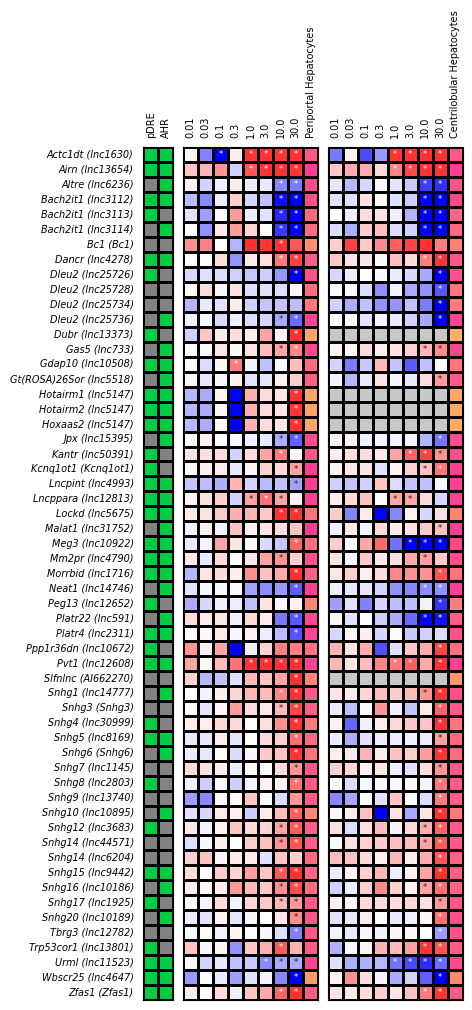

In [11]:
w = 14 / 3.4
h = len(GENES_AHR_DRE) / 3.4

fig = plt.figure(figsize=(w, h))

outer = gridspec.GridSpec(1, 3, width_ratios=[2, 9, 9], wspace=0.1)

# Defining inner grids for each outer grid cell
inner0 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0], width_ratios=[2], wspace=0)
inner2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[1], width_ratios=[8, 1], wspace=0)
inner3 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[2], width_ratios=[8, 1], wspace=0)

# Creating axes for each subplot
ax0 = plt.Subplot(fig, inner0[0])
ax2a = plt.Subplot(fig, inner2[0])
ax2b = plt.Subplot(fig, inner2[1])
ax3a = plt.Subplot(fig, inner3[0])
ax3b = plt.Subplot(fig, inner3[1])

# Hiding y-ticks for non-row-annotating subplots
ax2a.set_yticks([])
ax2b.set_yticks([])
ax3a.set_yticks([])
ax3b.set_yticks([])

lindwidth_var = 0.8

# Applying heatmaps with masks and colormaps
a = sns.heatmap(GENES_AHR_DRE, annot=False, linewidths=lindwidth_var, ax=ax0, square=True, linecolor='black', cbar=False, vmin=0, vmax=1, cmap=Gray_Green_cmap, xticklabels=True)
d = sns.heatmap(PP_LogFC_Full, mask=mask_PP_LogFC, annot=PP_Sig_Full, fmt='', linewidths=lindwidth_var, ax=ax2a, square=True, linecolor='black', cbar=False, yticklabels=False, vmin=-2, vmax=2, cmap=Red_Blue_cmap, xticklabels=True)
e = sns.heatmap(PP_Perc_GENES, mask=mask_PP_Perc, annot=False, linewidths=lindwidth_var, ax=ax2b, square=True, linecolor='black', cbar=False, yticklabels=False, vmin=0, vmax=100, cmap=Yellow_Pink_cmap, xticklabels=True)
f = sns.heatmap(PC_LogFC_Full, mask=mask_PC_LogFC, annot=PC_Sig_Full, fmt='', linewidths=lindwidth_var, ax=ax3a, square=True, linecolor='black', cbar=False, yticklabels=False, vmin=-2, vmax=2, cmap=Red_Blue_cmap, xticklabels=True)
g = sns.heatmap(PC_Perc_GENES, mask=mask_PC_Perc, annot=False, linewidths=lindwidth_var, ax=ax3b, square=True, linecolor='black', cbar=False, yticklabels=False, vmin=0, vmax=100, cmap=Yellow_Pink_cmap, xticklabels=True)

# Adding subplots to the figure
fig.add_subplot(ax0)
fig.add_subplot(ax2a)
fig.add_subplot(ax2b)
fig.add_subplot(ax3a)
fig.add_subplot(ax3b)

# Setting tick parameters
for ax in [ax0, ax2a, ax2b, ax3a, ax3b]:
    ax.tick_params(left=False, labelbottom=False, bottom=False, labeltop=True, rotation=90, labelsize=7)

# Setting facecolor to handle masked areas
d.set_facecolor('xkcd:silver')
e.set_facecolor('xkcd:silver')
f.set_facecolor('xkcd:silver')
g.set_facecolor('xkcd:silver')

# Adjusting y-tick labels for the first subplot
a.set_yticklabels(a.get_yticklabels(), rotation=0, style='italic')

# Ensuring all spines are visible
for ax in [a, d, e, f, g]:
    for _, spine in ax.spines.items():
        spine.set_visible(True)

# Set ylabel to empty for all axes to remove the y-axis title
for ax in [ax0, ax2a, ax2b, ax3a, ax3b]:
    ax.set_ylabel('')  # This removes the y-axis title
    
plt.savefig('./Figures/Named_DE_lncRNAs.pdf', format='pdf', bbox_inches='tight')

plt.show()
